In [7]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [9]:
game_stats = pd.read_csv('../csv/game_stats.csv')

In [10]:
game_stats["totalGoals"] = game_stats["home_goals"] + game_stats["away_goals"]
del game_stats["home_goals"]
del game_stats["away_goals"]
del game_stats["home_powerPlayGoals"]
del game_stats["away_powerPlayGoals"]
del game_stats["home_powerPlayOpportunities"]
del game_stats["away_powerPlayOpportunities"]


In [11]:
game_stats

,Unnamed: 0,home_pim,home_shots,home_powerPlayPercentage,home_faceOffWinPercentage,home_blocked,home_takeaways,home_giveaways,home_hits,away_pim,away_shots,away_powerPlayPercentage,away_faceOffWinPercentage,away_blocked,away_takeaways,away_giveaways,away_hits,totalGoals
0,0,10,29,0.0,68.2,17,5,2,23,12,15,33.3,31.8,8,6,4,23,6
1,1,10,27,0.0,51.6,13,8,16,45,4,40,40.0,48.4,4,3,9,22,4
2,2,4,41,50.0,41.4,18,4,10,24,4,15,50.0,58.6,11,4,9,13,7
3,3,2,46,50.0,45.6,9,8,12,29,6,39,0.0,54.4,13,6,6,20,7
4,4,2,24,66.7,57.1,7,3,19,23,6,34,0.0,42.9,15,9,9,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9496,9496,6,29,25.0,49.2,14,8,11,25,8,34,0.0,50.8,9,10,15,29,3
9497,9497,4,32,0.0,52.6,15,5,9,29,8,19,0.0,47.4,23,6,7,33,4
9498,9498,4,23,0.0,43.9,23,14,19,20,6,24,50.0,56.1,17,8,7,13,3
9499,9499,9,32,0.0,63.6,13,4,12,27,9,37,0.0,36.4,17,7,10,27,7


In [12]:
correlations = game_stats[game_stats.columns[1:]].corr()['totalGoals'][:]
lr_weights = np.array([c for c in correlations if c < 1.00])
lr_weights

array([ 0.08949497,  0.13011655,  0.27449957,  0.00613371, -0.05228897,
        0.03785528,  0.02259474, -0.05819319,  0.09065126,  0.1306554 ,
        0.25492709,  0.00430434, -0.06177959,  0.03822497,  0.0288119 ,
       -0.04682741])

In [45]:
x_df = game_stats.loc[:, game_stats.columns != "totalGoals"]
y_df = game_stats.loc[:, game_stats.columns == "totalGoals"]

x = np.array(x_df, dtype=np.float32).reshape(-1, 1)
y = np.array([[i[0] for i in np.array(y_df)]], dtype=np.float32)

x_train = x
y_train = y


print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (9501, 17)
y shape:  (9501, 1)


In [46]:

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [50]:
inputDim = 17        # takes variable 'x' 
outputDim = 1        # takes variable 'y'
learningRate = 0.01 
epochs = 100

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [51]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

tensor(70964.2578, grad_fn=<MseLossBackward0>)
epoch 0, loss 70964.2578125
tensor(2.5596e+18, grad_fn=<MseLossBackward0>)
epoch 1, loss 2.5596399797183447e+18
tensor(9.2713e+31, grad_fn=<MseLossBackward0>)
epoch 2, loss 9.27127048629705e+31
tensor(inf, grad_fn=<MseLossBackward0>)
epoch 3, loss inf
tensor(inf, grad_fn=<MseLossBackward0>)
epoch 4, loss inf
tensor(inf, grad_fn=<MseLossBackward0>)
epoch 5, loss inf
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 6, loss nan
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 7, loss nan
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 8, loss nan
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 9, loss nan
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 10, loss nan
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 11, loss nan
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 12, loss nan
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 13, loss nan
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 14, loss nan
tensor(nan, grad_fn=<MseLossBackward0>)
epoch 15, loss nan

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


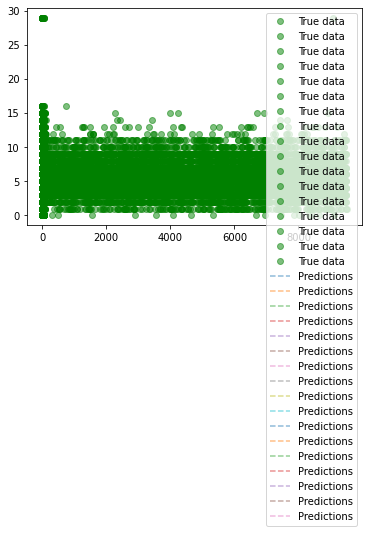

In [49]:
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()
    print(predicted)

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()